In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d


# Define LeNet-5 model without dropout for color images
class LeNet5Color(nn.Module):
    def __init__(self):
        super(LeNet5Color, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        conv1_output = torch.relu(x)
        x = self.pool(conv1_output)
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x, conv1_output

# Define the transformation for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the CIFAR-10 dataset
cifar_test = CIFAR10(root='./data', train=False, download=True, transform=transform)
dataloader = DataLoader(cifar_test, batch_size=1000, shuffle=False)

# List to store activations for each model
all_conv1_activations = []
all_labels = []

for n in range(10):
    # Load the pre-trained model
    model = LeNet5Color()
    model.load_state_dict(torch.load('model5_' + str(n) + '_9.pth'))
    model.eval()

    # Get the activations of the conv1 layer for the test set
    conv1_activations = None
    labels = None

    with torch.no_grad():
        for inputs, output_labels in dataloader:
            _, conv1_output = model(inputs)
            conv1_activations = conv1_output if conv1_activations is None else torch.cat((conv1_activations, conv1_output), 0)
            labels = output_labels if labels is None else torch.cat((labels, output_labels), 0)

    # Append activations to the list
    all_conv1_activations.append(conv1_activations.numpy())
    all_labels.append(labels.numpy())

smoothed_histograms_5_layers = all_conv1_activations
labels_5_layers = all_labels

Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model 0: Filter 4 (rank 0) with selectivity 0.9999999987568066
Model 1: Filter 3 (rank 0) with selectivity 0.99999999903608
Model 2: Filter 2 (rank 0) with selectivity 0.9999999990565014
Model 3: Filter 5 (rank 0) with selectivity 0.999999999002941
Model 4: Filter 0 (rank 0) with selectivity 0.9999999989582675
Model 5: Filter 5 (rank 0) with selectivity 0.9999999990508023
Model 6: Filter 4 (rank 0) with selectivity 0.9999999989452474
Model 7: Filter 4 (rank 0) with selectivity 0.9999999991356122
Model 8: Filter 1 (rank 0) with selectivity 0.9999999989329267
Model 9: Filter 2 (rank 0) with selectivity 0.9999999990

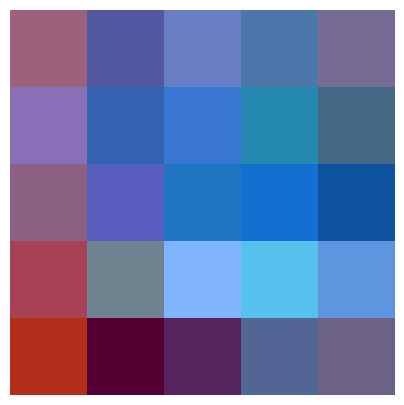

Selected activation shape: (2000,)


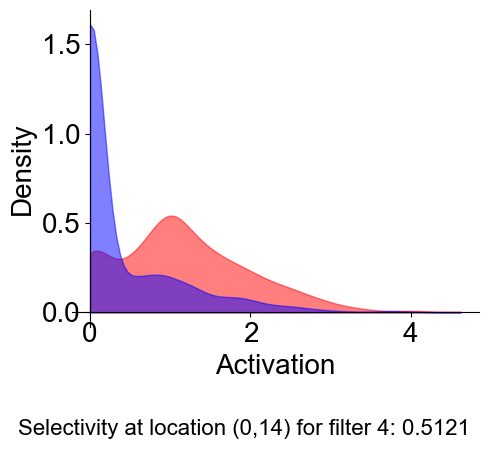

Top 4 image indices: [ 744    6  912 1235]
Files already downloaded and verified


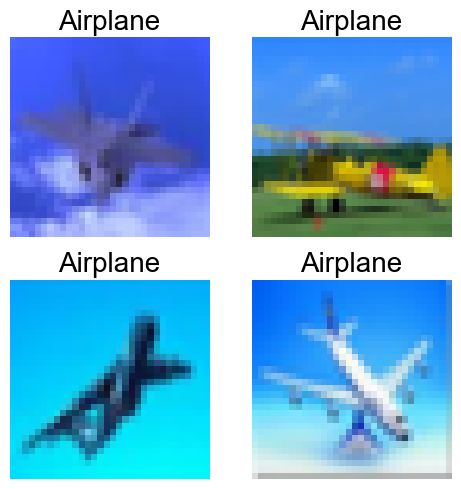

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from scipy.stats import gaussian_kde
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
import matplotlib as mpl

# Set font to Arial and enlarge tick label sizes
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

# ---------- Adjustable Parameters ----------
# Specify which classes to analyze (using CIFAR-10 original labels)
selected_classes = [0, 2]   # For example: [4,7] corresponds to "deer" and "horse"
# Map selected classes to their original names.
original_class_names = {0:"Airplane", 1:"automobile", 2:"Bird", 3:"cat", 4:"deer",
                        5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}
# Create a mapping: remapped labels 0,1,... correspond to the order in selected_classes.
selected_class_names = {i: original_class_names[c] for i, c in enumerate(selected_classes)}
num_classes_to_use = len(selected_classes)
# New parameter: choose filter rank: 0 = most selective, 1 = second most, -1 = least selective.
filter_rank = 0  # Set to -1 to choose the least selective filter.
# ---------- End Adjustable Parameters ----------

# Define the exact 5-layer LeNet-5 Model (architecture must match your pre-trained models)
class LeNet5Color(nn.Module):
    def __init__(self):
        super(LeNet5Color, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)   # First conv layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)   # Second conv layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        conv1_output = torch.relu(x)
        x = self.pool(conv1_output)
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x, conv1_output

# Modified function to compute class selectivity and return best spatial location per filter.
def compute_class_selectivity(activations, labels, num_classes=num_classes_to_use, epsilon=1e-9):
    """
    For each filter, compute the per-class mean activation at each spatial location.
    At each location:
         preferred = max(mean activations)
         remaining_avg = (sum(mean activations) - preferred) / (num_classes - 1)
         selectivity = (preferred - remaining_avg) / (preferred + remaining_avg + epsilon)
    Returns:
         selectivity_values: array (num_filters,) with maximum selectivity per filter,
         best_locations: list of (i,j) for each filter where the maximum occurs.
    """
    num_filters = activations.shape[1]
    H, W = activations.shape[2], activations.shape[3]
    selectivity_values = np.zeros(num_filters)
    best_locations = [None] * num_filters
    for f in range(num_filters):
        class_means = np.zeros((num_classes, H, W))
        # Use selected_classes order to remap labels.
        for idx, c in enumerate(selected_classes):
            mask = labels == c
            if np.any(mask):
                filtered = activations[mask, f, :, :]
                class_means[idx] = np.mean(filtered, axis=0)
        selectivity_map = np.zeros((H, W))
        for i in range(H):
            for j in range(W):
                vals = class_means[:, i, j]
                preferred = np.max(vals)
                remaining_avg = (np.sum(vals) - preferred) / (num_classes - 1)
                selectivity_map[i, j] = (preferred - remaining_avg) / (preferred + remaining_avg + epsilon)
        selectivity_values[f] = np.max(selectivity_map)
        idx_flat = np.argmax(selectivity_map)
        best_locations[f] = np.unravel_index(idx_flat, (H, W))
    return selectivity_values, best_locations

# Function to extract conv1 activations.
def get_activations(model, dataloader):
    model.eval()
    acts_list = []
    labs_list = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.numpy()
            x = torch.relu(model.conv1(inputs))
            acts_list.append(x.cpu().numpy())
            labs_list.append(labels)
    if acts_list:
        return np.concatenate(acts_list, axis=0), np.concatenate(labs_list, axis=0)
    else:
        return np.array([]), np.array([])

# Function to load and filter CIFAR-10 based on selected classes.
def get_filtered_dataloader(selected_classes, batch_size=4):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    full_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
    indices = [i for i, (img, label) in enumerate(full_dataset) if label in selected_classes]
    subset = torch.utils.data.Subset(full_dataset, indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=0)
    return loader, {c: i for i, c in enumerate(selected_classes)}

# New function: load visualization dataloader (without normalization).
def get_vis_dataloader(selected_classes, batch_size=1000):
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
    indices = [i for i, (img, label) in enumerate(full_dataset) if label in selected_classes]
    subset = torch.utils.data.Subset(full_dataset, indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=0)
    return loader

# -----------------------------------------------------------------
# Cycle through all 10 models and collect conv1 activations & remapped labels.
all_conv1_activations = []
all_labels = []
model_filenames = []
for n in range(10):
    fname = 'model5_' + str(n) + '_9.pth'
    model_filenames.append(fname)
    model = LeNet5Color().to(device)
    model.load_state_dict(torch.load(fname, map_location=device))
    model.eval()
    dataloader, class_mapping = get_filtered_dataloader(selected_classes, batch_size=1000)
    acts, labs = get_activations(model, dataloader)
    remapped_labels = np.vectorize(class_mapping.get)(labs)
    all_conv1_activations.append(acts)
    all_labels.append(remapped_labels)

# Compute selectivity for each model individually.
model_selectivities = []  # Each element: (model_idx, selectivities, chosen_filter, best_selectivity, best_locations)
for i, (acts, labs) in enumerate(zip(all_conv1_activations, all_labels)):
    sel, locs = compute_class_selectivity(acts, labs, num_classes=num_classes_to_use)
    sorted_indices = np.argsort(-sel)  # Descending order
    # Use filter_rank: if -1, choose least selective; else choose rank-th most selective.
    if filter_rank < 0:
        chosen_filter = np.argmin(sel)
    elif filter_rank >= len(sorted_indices):
        chosen_filter = sorted_indices[0]
    else:
        chosen_filter = sorted_indices[filter_rank]
    best_sel = sel[chosen_filter]
    model_selectivities.append((i, sel, chosen_filter, best_sel, locs))
    print(f"Model {i}: Filter {chosen_filter} (rank {filter_rank}) with selectivity {best_sel}")

# Choose the overall best model/filter pair (by maximum selectivity).
best_model_idx = None
best_filter_idx_overall = None
best_selectivity_overall = -np.inf
best_location = None
for (i, sel, bf, bs, locs) in model_selectivities:
    if bs > best_selectivity_overall:
        best_selectivity_overall = bs
        best_model_idx = i
        best_filter_idx_overall = bf
        best_location = locs[bf]
print("Overall best model index:", best_model_idx)
print("Overall best filter index (by rank):", best_filter_idx_overall)
print("Overall best selectivity:", best_selectivity_overall)
print("Best location (i,j):", best_location)

# --- Visualize the best filter weights from the best model ---
best_model = LeNet5Color().to(device)
best_model.load_state_dict(torch.load(model_filenames[best_model_idx], map_location=device))
with torch.no_grad():
    weights = best_model.conv1.weight.cpu().numpy()  # shape: (6, 3, 5, 5)
# Visualize the best filter in full color.
best_filter_weights = weights[best_filter_idx_overall].transpose(1,2,0)  # (5,5,3)
best_filter_weights = (best_filter_weights - best_filter_weights.min()) / (best_filter_weights.max() - best_filter_weights.min())
plt.figure(figsize=(5,5))
plt.imshow(best_filter_weights)
plt.axis('off')
plt.show()

# --- For histogram and image analysis, use activations from the best model ---
vis_activations = all_conv1_activations[best_model_idx]  # shape: (N, 6, H, W)
vis_labels = all_labels[best_model_idx]                    # shape: (N,)
N = vis_activations.shape[0]
# Use the activation at the best spatial location (i_sel, j_sel) for the chosen filter.
i_sel, j_sel = best_location
selected_acts = vis_activations[:, best_filter_idx_overall, i_sel, j_sel]  # shape: (N,)
print("Selected activation shape:", selected_acts.shape)

# --- Smooth histogram of activations per class (filled only) ---
plt.figure(figsize=(5, 4))
classes = np.unique(vis_labels)
x_vals = np.linspace(np.min(selected_acts), np.max(selected_acts), 100)

for cl in classes:
    inds = np.where(vis_labels == cl)[0]
    orig_label = selected_classes[cl]
    if len(inds) > 1:
        kde = gaussian_kde(selected_acts[inds])
        density = kde(x_vals)   # Convert to percent
        color = 'red' if cl == 0 else 'blue'
        plt.fill_between(x_vals, density, alpha=0.5, color=color)
    else:
        plt.hist(selected_acts[inds], bins=20, alpha=0.5, color=plt.cm.jet(orig_label / 10))

plt.xlabel("Activation", fontsize=20)
plt.ylabel("Density", fontsize=20)


# Style axes
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))

# --- Compute and print selectivity at (i_sel, j_sel) for this filter ---
num_filters = vis_activations.shape[1]
class_means = np.zeros((num_classes_to_use, vis_activations.shape[2], vis_activations.shape[3]))
for idx, c in enumerate(selected_classes):
    mask = vis_labels == idx
    if np.any(mask):
        class_means[idx] = np.mean(vis_activations[mask, best_filter_idx_overall], axis=0)

vals = class_means[:, i_sel, j_sel]
preferred = np.max(vals)
remaining_avg = (np.sum(vals) - preferred) / (num_classes_to_use - 1)
selectivity_at_ij = (preferred - remaining_avg) / (preferred + remaining_avg + 1e-9)

# Add text under the plot
plt.figtext(0.5, -0.1, f"Selectivity at location ({i_sel},{j_sel}) for filter {best_filter_idx_overall}: {selectivity_at_ij:.4f}",
            wrap=True, horizontalalignment='center', fontsize=16)

plt.tight_layout()
plt.show()


# --- Display top 4 images (2x2 grid) that most activate the best filter ---
top_indices = np.argsort(selected_acts)[-4:]
print("Top 4 image indices:", top_indices)

# Use visualization dataloader (without normalization) for original images.
vis_loader = get_vis_dataloader(selected_classes, batch_size=1000)
imgs_list = []
with torch.no_grad():
    for inputs, _ in vis_loader:
        imgs_list.append(inputs)
images_all = torch.cat(imgs_list, dim=0)  # shape: (N_filtered, C, H, W)

plt.figure(figsize=(5,5))
for i, idx in enumerate(top_indices):
    plt.subplot(2, 2, i+1)
    img = ToPILImage()(images_all[idx])
    plt.imshow(img)
    plt.title(selected_class_names.get(vis_labels[idx], str(vis_labels[idx])), fontsize=20)
    plt.axis('off')
plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model 0: Filter 0 (rank -3) with selectivity 0.999999996681752
Model 1: Filter 5 (rank -3) with selectivity 0.9999999968697821
Model 2: Filter 0 (rank -3) with selectivity 0.9999999965737625
Model 3: Filter 4 (rank -3) with selectivity 0.9999999967372261
Model 4: Filter 1 (rank -3) with selectivity 0.9999999968587809
Model 5: Filter 1 (rank -3) with selectivity 0.9999999965486055
Model 6: Filter 5 (rank -3) with selectivity 0.9999999969287106
Model 7: Filter 0 (rank -3) with selectivity 0.9999999973004432
Model 8: Filter 3 (rank -3) with selectivity 0.9999999972749963
Model 9: Filter 3 (rank -3) with selectivity 

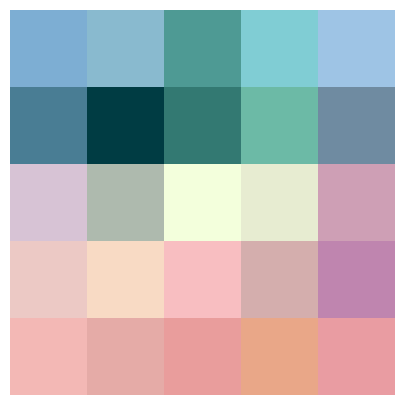

Selected activation shape: (2000,)


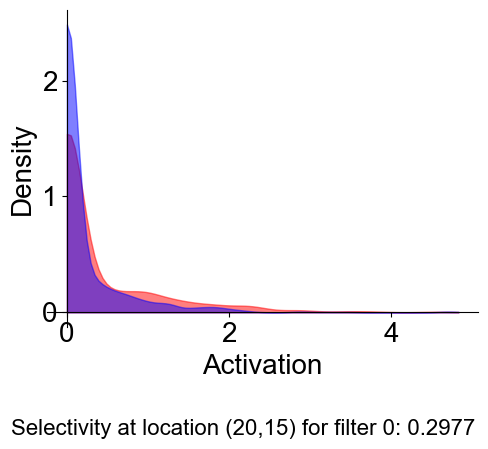

Top 4 image indices: [   2 1596 1618  745]
Files already downloaded and verified


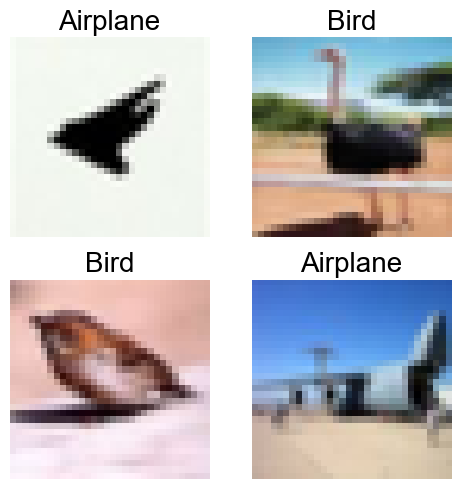

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from scipy.stats import gaussian_kde
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
import matplotlib as mpl

# Set font to Arial and enlarge tick label sizes
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

# ---------- Adjustable Parameters ----------
# Specify which classes to analyze (using CIFAR-10 original labels)
selected_classes = [0, 2]   # For example: [4,7] corresponds to "deer" and "horse"
# Map selected classes to their original names.
original_class_names = {0:"Airplane", 1:"automobile", 2:"Bird", 3:"cat", 4:"deer",
                        5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}
# Create a mapping: remapped labels 0,1,... correspond to the order in selected_classes.
selected_class_names = {i: original_class_names[c] for i, c in enumerate(selected_classes)}
num_classes_to_use = len(selected_classes)
# New parameter: choose filter rank: 0 = most selective, 1 = second most, -1 = least selective.
filter_rank = -3  # Set to -1 to choose the least selective filter.
# ---------- End Adjustable Parameters ----------

# Define the exact 5-layer LeNet-5 Model (architecture must match your pre-trained models)
class LeNet5Color(nn.Module):
    def __init__(self):
        super(LeNet5Color, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)   # First conv layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)   # Second conv layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        conv1_output = torch.relu(x)
        x = self.pool(conv1_output)
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x, conv1_output

# Modified function to compute class selectivity and return best spatial location per filter.
def compute_class_selectivity(activations, labels, num_classes=num_classes_to_use, epsilon=1e-9):
    """
    For each filter, compute the per-class mean activation at each spatial location.
    At each location:
         preferred = max(mean activations)
         remaining_avg = (sum(mean activations) - preferred) / (num_classes - 1)
         selectivity = (preferred - remaining_avg) / (preferred + remaining_avg + epsilon)
    Returns:
         selectivity_values: array (num_filters,) with maximum selectivity per filter,
         best_locations: list of (i,j) for each filter where the maximum occurs.
    """
    num_filters = activations.shape[1]
    H, W = activations.shape[2], activations.shape[3]
    selectivity_values = np.zeros(num_filters)
    best_locations = [None] * num_filters
    for f in range(num_filters):
        class_means = np.zeros((num_classes, H, W))
        # Use selected_classes order to remap labels.
        for idx, c in enumerate(selected_classes):
            mask = labels == c
            if np.any(mask):
                filtered = activations[mask, f, :, :]
                class_means[idx] = np.mean(filtered, axis=0)
        selectivity_map = np.zeros((H, W))
        for i in range(H):
            for j in range(W):
                vals = class_means[:, i, j]
                preferred = np.max(vals)
                remaining_avg = (np.sum(vals) - preferred) / (num_classes - 1)
                selectivity_map[i, j] = (preferred - remaining_avg) / (preferred + remaining_avg + epsilon)
        selectivity_values[f] = np.max(selectivity_map)
        idx_flat = np.argmax(selectivity_map)
        best_locations[f] = np.unravel_index(idx_flat, (H, W))
    return selectivity_values, best_locations

# Function to extract conv1 activations.
def get_activations(model, dataloader):
    model.eval()
    acts_list = []
    labs_list = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.numpy()
            x = torch.relu(model.conv1(inputs))
            acts_list.append(x.cpu().numpy())
            labs_list.append(labels)
    if acts_list:
        return np.concatenate(acts_list, axis=0), np.concatenate(labs_list, axis=0)
    else:
        return np.array([]), np.array([])

# Function to load and filter CIFAR-10 based on selected classes.
def get_filtered_dataloader(selected_classes, batch_size=4):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    full_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
    indices = [i for i, (img, label) in enumerate(full_dataset) if label in selected_classes]
    subset = torch.utils.data.Subset(full_dataset, indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=0)
    return loader, {c: i for i, c in enumerate(selected_classes)}

# New function: load visualization dataloader (without normalization).
def get_vis_dataloader(selected_classes, batch_size=1000):
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
    indices = [i for i, (img, label) in enumerate(full_dataset) if label in selected_classes]
    subset = torch.utils.data.Subset(full_dataset, indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=0)
    return loader

# -----------------------------------------------------------------
# Cycle through all 10 models and collect conv1 activations & remapped labels.
all_conv1_activations = []
all_labels = []
model_filenames = []
for n in range(10):
    fname = 'model5_' + str(n) + '_9.pth'
    model_filenames.append(fname)
    model = LeNet5Color().to(device)
    model.load_state_dict(torch.load(fname, map_location=device))
    model.eval()
    dataloader, class_mapping = get_filtered_dataloader(selected_classes, batch_size=1000)
    acts, labs = get_activations(model, dataloader)
    remapped_labels = np.vectorize(class_mapping.get)(labs)
    all_conv1_activations.append(acts)
    all_labels.append(remapped_labels)

# Compute selectivity for each model individually.
model_selectivities = []  # Each element: (model_idx, selectivities, chosen_filter, best_selectivity, best_locations)
for i, (acts, labs) in enumerate(zip(all_conv1_activations, all_labels)):
    sel, locs = compute_class_selectivity(acts, labs, num_classes=num_classes_to_use)
    sorted_indices = np.argsort(sel)  # ascending order: least to most selective

    if filter_rank < 0:
        chosen_filter = sorted_indices[filter_rank]  # -1 = last in list = least selective
    else:
        chosen_filter = sorted_indices[::-1][filter_rank]  # descending order
    best_sel = sel[chosen_filter]
    model_selectivities.append((i, sel, chosen_filter, best_sel, locs))
    print(f"Model {i}: Filter {chosen_filter} (rank {filter_rank}) with selectivity {best_sel}")

# Choose the overall best model/filter pair (by maximum selectivity).
best_model_idx = None
best_filter_idx_overall = None
best_selectivity_overall = -np.inf
best_location = None
for (i, sel, bf, bs, locs) in model_selectivities:
    if bs > best_selectivity_overall:
        best_selectivity_overall = bs
        best_model_idx = i
        best_filter_idx_overall = bf
        best_location = locs[bf]
print("Overall best model index:", best_model_idx)
print("Overall best filter index (by rank):", best_filter_idx_overall)
print("Overall best selectivity:", best_selectivity_overall)
print("Best location (i,j):", best_location)

# --- Visualize the best filter weights from the best model ---
best_model = LeNet5Color().to(device)
best_model.load_state_dict(torch.load(model_filenames[best_model_idx], map_location=device))
with torch.no_grad():
    weights = best_model.conv1.weight.cpu().numpy()  # shape: (6, 3, 5, 5)
# Visualize the best filter in full color.
best_filter_weights = weights[best_filter_idx_overall].transpose(1,2,0)  # (5,5,3)
best_filter_weights = (best_filter_weights - best_filter_weights.min()) / (best_filter_weights.max() - best_filter_weights.min())
plt.figure(figsize=(5,5))
plt.imshow(best_filter_weights)
plt.axis('off')
plt.show()

# --- For histogram and image analysis, use activations from the best model ---
vis_activations = all_conv1_activations[best_model_idx]  # shape: (N, 6, H, W)
vis_labels = all_labels[best_model_idx]                    # shape: (N,)
N = vis_activations.shape[0]
# Use the activation at the best spatial location (i_sel, j_sel) for the chosen filter.
i_sel, j_sel = best_location
selected_acts = vis_activations[:, best_filter_idx_overall, i_sel, j_sel]  # shape: (N,)
print("Selected activation shape:", selected_acts.shape)

# --- Smooth histogram of activations per class (filled only) ---
plt.figure(figsize=(5, 4))
classes = np.unique(vis_labels)
x_vals = np.linspace(np.min(selected_acts), np.max(selected_acts), 100)

for cl in classes:
    inds = np.where(vis_labels == cl)[0]
    orig_label = selected_classes[cl]
    if len(inds) > 1:
        kde = gaussian_kde(selected_acts[inds])
        density = kde(x_vals)   # Convert to percent
        color = 'red' if cl == 0 else 'blue'
        plt.fill_between(x_vals, density, alpha=0.5, color=color)
    else:
        plt.hist(selected_acts[inds], bins=20, alpha=0.5, color=plt.cm.jet(orig_label / 10))

plt.xlabel("Activation", fontsize=20)
plt.ylabel("Density", fontsize=20)


# Style axes
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))

# --- Compute and print selectivity at (i_sel, j_sel) for this filter ---
num_filters = vis_activations.shape[1]
class_means = np.zeros((num_classes_to_use, vis_activations.shape[2], vis_activations.shape[3]))
for idx, c in enumerate(selected_classes):
    mask = vis_labels == idx
    if np.any(mask):
        class_means[idx] = np.mean(vis_activations[mask, best_filter_idx_overall], axis=0)

vals = class_means[:, i_sel, j_sel]
preferred = np.max(vals)
remaining_avg = (np.sum(vals) - preferred) / (num_classes_to_use - 1)
selectivity_at_ij = (preferred - remaining_avg) / (preferred + remaining_avg + 1e-9)

# Add text under the plot
plt.figtext(0.5, -0.1, f"Selectivity at location ({i_sel},{j_sel}) for filter {best_filter_idx_overall}: {selectivity_at_ij:.4f}",
            wrap=True, horizontalalignment='center', fontsize=16)

plt.tight_layout()
plt.show()


# --- Display top 4 images (2x2 grid) that most activate the best filter ---
top_indices = np.argsort(selected_acts)[-4:]
print("Top 4 image indices:", top_indices)

# Use visualization dataloader (without normalization) for original images.
vis_loader = get_vis_dataloader(selected_classes, batch_size=1000)
imgs_list = []
with torch.no_grad():
    for inputs, _ in vis_loader:
        imgs_list.append(inputs)
images_all = torch.cat(imgs_list, dim=0)  # shape: (N_filtered, C, H, W)

plt.figure(figsize=(5,5))
for i, idx in enumerate(top_indices):
    plt.subplot(2, 2, i+1)
    img = ToPILImage()(images_all[idx])
    plt.imshow(img)
    plt.title(selected_class_names.get(vis_labels[idx], str(vis_labels[idx])), fontsize=20)
    plt.axis('off')
plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Model 0: Filter 5 (rank -1) with selectivity 0.999999993076337
Model 1: Filter 2 (rank -1) with selectivity 0.9999999954629083
Model 2: Filter 1 (rank -1) with selectivity 0.9999999959664797
Model 3: Filter 2 (rank -1) with selectivity 0.9999999964870318
Model 4: Filter 5 (rank -1) with selectivity 0.999999994797921
Model 5: Filter 2 (rank -1) with selectivity 0.9999999946576748
Model 6: Filter 0 (rank -1) with selectivity 0.999999995477985
Model 7: Filter 5 (rank -1) with selectivity 0.9999999962480822
Model 8: Filter 4 (rank -1) with selectivity 0.9999999955889531
Model 9: Filter 0 (rank -1) with selectivity 0.

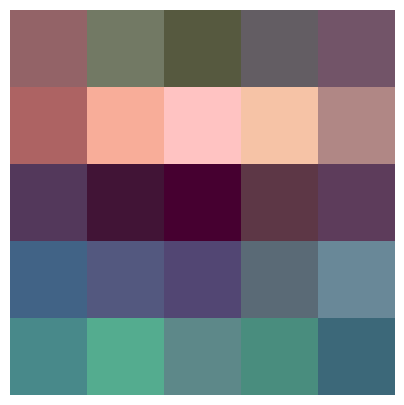

Center location (i,j): (14, 14)
Selected activation shape (center): (2000,)


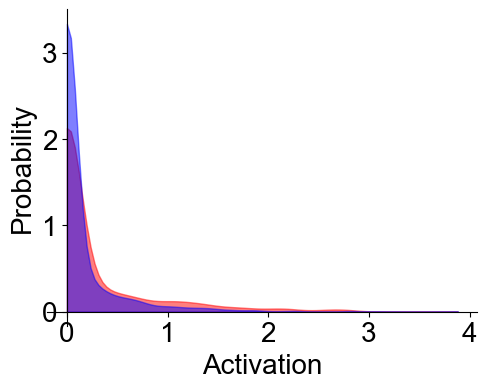

Top 4 image indices: [ 762  825  369 1562]
Files already downloaded and verified


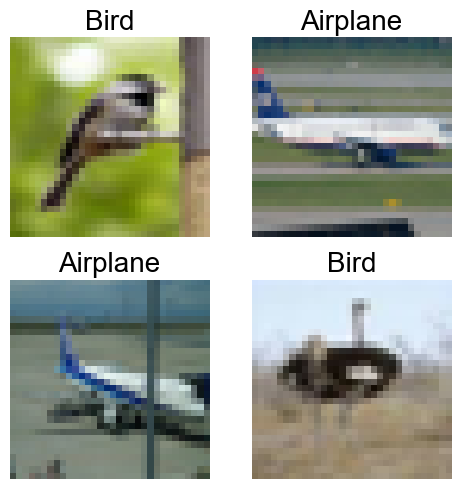

In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from scipy.stats import gaussian_kde
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
import matplotlib as mpl

# Set font to Arial and adjust tick label sizes
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

# ---------- Adjustable Parameters ----------
# Specify which classes to analyze (using CIFAR-10 original labels)
selected_classes = [0, 2]   # For example: [4,7] corresponds to "deer" and "horse"
# Map selected classes to their original names.
original_class_names = {0:"Airplane", 1:"automobile", 2:"Bird", 3:"cat", 4:"deer",
                        5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}
# Remap so that first selected becomes label 0, second becomes label 1, etc.
selected_class_names = {i: original_class_names[c] for i, c in enumerate(selected_classes)}
num_classes_to_use = len(selected_classes)
# Choose filter rank: 0 = highest (if selectivity_mode=="max") or lowest (if "min"), etc.
filter_rank = -1
# Choose the selectivity mode: "max" for most selective location; "min" for least selective.
selectivity_mode = "max"
# ---------- End Adjustable Parameters ----------

# Define the exact 5-layer LeNet-5 Model (must match your pre-trained models)
class LeNet5Color(nn.Module):
    def __init__(self):
        super(LeNet5Color, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)   # First conv layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)   # Second conv layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        conv1_output = torch.relu(x)
        x = self.pool(conv1_output)
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x, conv1_output

# Function to compute class selectivity (returns extreme value and its location).
def compute_class_selectivity(activations, labels, num_classes=num_classes_to_use, epsilon=1e-9, mode="max"):
    num_filters = activations.shape[1]
    H, W = activations.shape[2], activations.shape[3]
    selectivity_values = np.zeros(num_filters)
    best_locations = [None] * num_filters
    for f in range(num_filters):
        class_means = np.zeros((num_classes, H, W))
        for idx, c in enumerate(selected_classes):
            mask = labels == c
            if np.any(mask):
                filtered = activations[mask, f, :, :]
                class_means[idx] = np.mean(filtered, axis=0)
        selectivity_map = np.zeros((H, W))
        for i in range(H):
            for j in range(W):
                vals = class_means[:, i, j]
                preferred = np.max(vals)
                remaining_avg = (np.sum(vals) - preferred) / (num_classes - 1)
                selectivity_map[i, j] = (preferred - remaining_avg) / (preferred + remaining_avg + epsilon)
        if mode == "max":
            selectivity_values[f] = np.max(selectivity_map)
            idx_flat = np.argmax(selectivity_map)
        elif mode == "min":
            selectivity_values[f] = np.min(selectivity_map)
            idx_flat = np.argmin(selectivity_map)
        else:
            raise ValueError("mode must be 'max' or 'min'")
        best_locations[f] = np.unravel_index(idx_flat, (H, W))
    return selectivity_values, best_locations

# Function to extract conv1 activations.
def get_activations(model, dataloader):
    model.eval()
    acts_list = []
    labs_list = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.numpy()
            x = torch.relu(model.conv1(inputs))
            acts_list.append(x.cpu().numpy())
            labs_list.append(labels)
    if acts_list:
        return np.concatenate(acts_list, axis=0), np.concatenate(labs_list, axis=0)
    else:
        return np.array([]), np.array([])

# Function to load and filter CIFAR-10 based on selected classes.
def get_filtered_dataloader(selected_classes, batch_size=4):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
    full_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
    indices = [i for i, (img, label) in enumerate(full_dataset) if label in selected_classes]
    subset = torch.utils.data.Subset(full_dataset, indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=0)
    return loader, {c: i for i, c in enumerate(selected_classes)}

# New function: load visualization dataloader (without normalization).
def get_vis_dataloader(selected_classes, batch_size=1000):
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
    indices = [i for i, (img, label) in enumerate(full_dataset) if label in selected_classes]
    subset = torch.utils.data.Subset(full_dataset, indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=0)
    return loader

# -----------------------------------------------------------------
# Cycle through all 10 models and collect conv1 activations & remapped labels.
all_conv1_activations = []
all_labels = []
model_filenames = []
for n in range(10):
    fname = 'model5_' + str(n) + '_9.pth'
    model_filenames.append(fname)
    model = LeNet5Color().to(device)
    model.load_state_dict(torch.load(fname, map_location=device))
    model.eval()
    dataloader, class_mapping = get_filtered_dataloader(selected_classes, batch_size=1000)
    acts, labs = get_activations(model, dataloader)
    remapped_labels = np.vectorize(class_mapping.get)(labs)
    all_conv1_activations.append(acts)
    all_labels.append(remapped_labels)

# Compute selectivity for each model individually.
model_selectivities = []  # Each element: (model_idx, selectivities, chosen_filter, best_selectivity, best_locations)
for i, (acts, labs) in enumerate(zip(all_conv1_activations, all_labels)):
    sel, locs = compute_class_selectivity(acts, labs, num_classes=num_classes_to_use, mode=selectivity_mode)
    sorted_indices = np.argsort(sel) if selectivity_mode=="min" else np.argsort(-sel)
    if filter_rank < 0:
        chosen_filter = np.argmin(sel)
    elif filter_rank >= len(sorted_indices):
        chosen_filter = sorted_indices[0]
    else:
        chosen_filter = sorted_indices[filter_rank]
    best_sel = sel[chosen_filter]
    model_selectivities.append((i, sel, chosen_filter, best_sel, locs))
    print(f"Model {i}: Filter {chosen_filter} (rank {filter_rank}) with selectivity {best_sel}")

# Choose the overall best model/filter pair (by maximum selectivity if mode=="max", or minimum if mode=="min").
best_model_idx = None
best_filter_idx_overall = None
if selectivity_mode=="max":
    best_selectivity_overall = -np.inf
else:
    best_selectivity_overall = np.inf
best_location = None
for (i, sel, bf, bs, locs) in model_selectivities:
    if (selectivity_mode=="max" and bs > best_selectivity_overall) or (selectivity_mode=="min" and bs < best_selectivity_overall):
        best_selectivity_overall = bs
        best_model_idx = i
        best_filter_idx_overall = bf
        best_location = locs[bf]
print("Overall best model index:", best_model_idx)
print("Overall best filter index (by rank):", best_filter_idx_overall)
print("Overall best selectivity:", best_selectivity_overall)
print("Best location (i,j):", best_location)

# --- Visualize the best filter weights from the best model ---
best_model = LeNet5Color().to(device)
best_model.load_state_dict(torch.load(model_filenames[best_model_idx], map_location=device))
with torch.no_grad():
    weights = best_model.conv1.weight.cpu().numpy()  # shape: (6, 3, 5, 5)
best_filter_weights = weights[best_filter_idx_overall].transpose(1,2,0)  # (5,5,3)
best_filter_weights = (best_filter_weights - best_filter_weights.min()) / (best_filter_weights.max() - best_filter_weights.min())
plt.figure(figsize=(5,5))
plt.imshow(best_filter_weights)
plt.axis('off')
plt.show()

# --- For histogram and image analysis, use activations from the best model ---
vis_activations = all_conv1_activations[best_model_idx]  # shape: (N, 6, H, W)
vis_labels = all_labels[best_model_idx]                    # shape: (N,)
N = vis_activations.shape[0]
# Instead of using the computed location, we now use the center location.
H, W = vis_activations.shape[2], vis_activations.shape[3]
center_location = (H//2, W//2)
print("Center location (i,j):", center_location)
selected_acts = vis_activations[:, best_filter_idx_overall, center_location[0], center_location[1]]  # shape: (N,)
print("Selected activation shape (center):", selected_acts.shape)

# --- Smooth histogram of activations per class (filled only) ---
plt.figure(figsize=(5, 4))
classes = np.unique(vis_labels)
x_vals = np.linspace(np.min(selected_acts), np.max(selected_acts), 100)

for cl in classes:
    inds = np.where(vis_labels == cl)[0]
    orig_label = selected_classes[cl]
    if len(inds) > 1:
        kde = gaussian_kde(selected_acts[inds])
        density = kde(x_vals)  # Convert to percent
        color = 'red' if cl == 0 else 'blue'
        plt.fill_between(x_vals, density, alpha=0.5, color=color)
       # plt.fill_between(x_vals, density, alpha=0.3, color=plt.cm.jet(orig_label / 10))
    else:
        plt.hist(selected_acts[inds], bins=20, alpha=0.5, color=plt.cm.jet(orig_label / 10))

plt.xlabel("Activation", fontsize=20)
plt.ylabel("Probability", fontsize=20)


# Style axes
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))

# --- Compute and print selectivity at (i_sel, j_sel) for this filter ---
num_filters = vis_activations.shape[1]
class_means = np.zeros((num_classes_to_use, vis_activations.shape[2], vis_activations.shape[3]))
for idx, c in enumerate(selected_classes):
    mask = vis_labels == idx
    if np.any(mask):
        class_means[idx] = np.mean(vis_activations[mask, best_filter_idx_overall], axis=0)

vals = class_means[:, i_sel, j_sel]
preferred = np.max(vals)
remaining_avg = (np.sum(vals) - preferred) / (num_classes_to_use - 1)
selectivity_at_ij = (preferred - remaining_avg) / (preferred + remaining_avg + 1e-9)

# Add text under the plot
#plt.figtext(0.5, -0.1, f"Selectivity at location ({i_sel},{j_sel}) for filter {best_filter_idx_overall}: {selectivity_at_ij:.4f}",
#            wrap=True, horizontalalignment='center', fontsize=16)

plt.tight_layout()
plt.show()

# --- Display top 4 images (2x2 grid) that most activate the best filter at the center location ---
top_indices = np.argsort(selected_acts)[-4:]
print("Top 4 image indices:", top_indices)
# Use visualization dataloader (without normalization) for original images.
vis_loader = get_vis_dataloader(selected_classes, batch_size=1000)
imgs_list = []
with torch.no_grad():
    for inputs, _ in vis_loader:
        imgs_list.append(inputs)
images_all = torch.cat(imgs_list, dim=0)  # shape: (N_filtered, C, H, W)
plt.figure(figsize=(5,5))
for i, idx in enumerate(top_indices):
    plt.subplot(2, 2, i+1)
    img = ToPILImage()(images_all[idx])
    plt.imshow(img)
    plt.title(selected_class_names.get(vis_labels[idx], str(vis_labels[idx])), fontsize=20)
    plt.axis('off')
plt.tight_layout()
plt.show()

Files already downloaded and verified


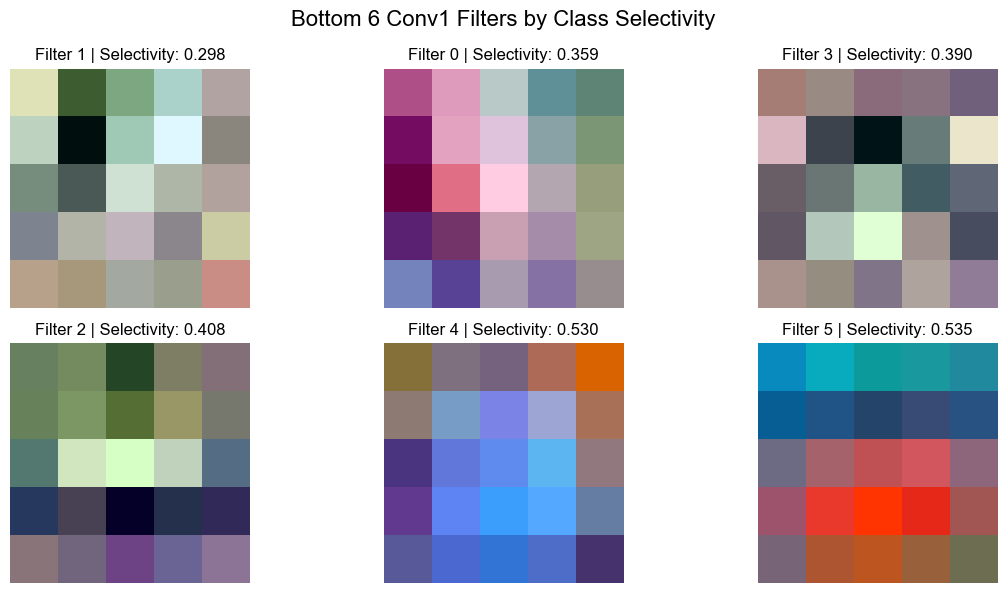

In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

# ---------- Style ----------
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

# ---------- Setup ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Model ----------
class LeNet5Color(nn.Module):
    def __init__(self):
        super(LeNet5Color, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        conv1_out = torch.relu(x)
        x = self.pool(conv1_out)
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x, conv1_out

# ---------- Load Model ----------
model_path = 'model5_0_9.pth'
model = LeNet5Color().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ---------- Load CIFAR-10 ----------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)

# ---------- Collect Activations ----------
all_acts = []
all_labels = []
with torch.no_grad():
    for inputs, labels in loader:
        inputs = inputs.to(device)
        _, conv1_out = model(inputs)
        all_acts.append(conv1_out.cpu().numpy())
        all_labels.append(labels.numpy())

acts = np.concatenate(all_acts, axis=0)  # (N, 6, H, W)
labels = np.concatenate(all_labels, axis=0)

num_filters, H, W = acts.shape[1], acts.shape[2], acts.shape[3]

# ---------- Compute Selectivity ----------
class_means = np.zeros((10, num_filters, H, W))
for cl in range(10):
    mask = labels == cl
    if np.any(mask):
        class_means[cl] = np.mean(acts[mask], axis=0)

selectivities = np.zeros(num_filters)
for f in range(num_filters):
    sel_map = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            vals = class_means[:, f, i, j]
            preferred = np.max(vals)
            remaining_avg = (np.sum(vals) - preferred) / (9 + 1e-9)
            sel_map[i, j] = (preferred - remaining_avg) / (preferred + remaining_avg + 1e-9)
    selectivities[f] = np.max(sel_map)

# ---------- Sort Filters by Lowest Selectivity ----------
sorted_filters = np.argsort(selectivities)  # ascending order

# ---------- Visualize Bottom 6 Conv1 Filters ----------
weights = model.conv1.weight.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
for i, f_idx in enumerate(sorted_filters[:6]):  # bottom 6
    w = weights[f_idx].transpose(1, 2, 0)  # (5,5,3)
    w = (w - w.min()) / (w.max() - w.min())  # Normalize to [0,1]

    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(w)
    ax.set_title(f'Filter {f_idx} | Selectivity: {selectivities[f_idx]:.3f}', fontsize=12)
    ax.axis('off')

plt.suptitle("Bottom 6 Conv1 Filters by Class Selectivity", fontsize=16)
plt.tight_layout()
plt.show()